# Урок 2. Обзор основных алгоритмов машинного обучения, используемых в соревнованиях

**Задание 1:**

**Отобрать только числовые признаки и обучить модель XGBoost с параметром booster = gbtree. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).**

In [68]:
from typing import List,Optional
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import os

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score,train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

import missingno as msno
import xgboost as xgb


Загрузка данных

In [69]:
DATA_PATH="Data"
def load_data(dataset_name,data_path=DATA_PATH):
    csv_path = os.path.join(data_path,dataset_name)
    return pd.read_csv(csv_path)

In [70]:
train = load_data("assignment_2_train.csv")
test = load_data("assignment_2_test.csv")

In [71]:
#Размерности датасетов
print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))

train.shape = 180000 rows, 394 cols
test.shape = 100001 rows, 394 cols


Получение значения сводной статистикам по всем значениям train, test

In [72]:
train.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,1.800000e+05,180000.000000,1.800000e+05,180000.000000,180000.000000,177389.000000,179997.000000,179047.000000,160567.000000,160567.000000,...,47996.000000,47996.000000,47996.000000,47996.000000,47996.000000,47996.000000,47996.000000,47996.000000,47996.000000,47996.000000
mean,3.077000e+06,0.028561,1.909818e+06,129.514237,9860.225806,368.326897,153.410374,200.363089,291.160444,86.559903,...,0.137074,74.962242,99.220468,85.778161,8.326725,18.404676,12.437524,26.798593,32.005349,28.492421
std,5.196167e+04,0.166570,1.039029e+06,206.515032,4910.778205,158.952840,11.529483,40.585532,102.250385,3.958070,...,0.642444,545.161980,668.223140,577.072150,84.616132,120.896921,99.305885,252.695682,284.870583,258.372941
min,2.987000e+06,0.000000,8.640000e+04,0.292000,1001.000000,100.000000,100.000000,100.000000,100.000000,10.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.032000e+06,0.000000,1.091681e+06,44.000000,6019.000000,215.000000,150.000000,166.000000,204.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.077000e+06,0.000000,1.884075e+06,75.000000,9633.000000,375.000000,150.000000,226.000000,299.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.121999e+06,0.000000,2.693196e+06,125.000000,14182.000000,514.000000,150.000000,226.000000,330.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.166999e+06,1.000000,3.958317e+06,5278.950000,18396.000000,600.000000,231.000000,237.000000,540.000000,102.000000,...,15.000000,20750.000000,32250.000000,21250.000000,3100.000000,3350.000000,3250.000000,8250.000000,8250.000000,8250.000000


In [73]:
test.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,1.000010e+05,100001.000000,1.000010e+05,100001.000000,100001.000000,98325.000000,99185.000000,98701.000000,88300.000000,88300.000000,...,6774.000000,6774.000000,6774.000000,6774.000000,6774.000000,6774.000000,6774.000000,6774.000000,6774.000000,6774.000000
mean,3.337000e+06,0.038040,8.696663e+06,140.674821,9882.200528,357.652672,153.271785,198.466672,289.507758,86.863941,...,0.192944,81.733429,123.824365,91.572815,6.744021,36.245940,11.969737,47.597468,52.675413,48.497675
std,2.886795e+04,0.191293,7.603909e+05,240.272633,4867.290775,156.984512,11.512903,41.495035,101.589641,2.143002,...,0.606917,715.898781,777.526194,718.203590,214.832591,269.734936,216.315923,597.985868,600.451426,598.024560
min,3.287000e+06,0.000000,7.415038e+06,0.251000,1004.000000,100.000000,100.000000,100.000000,104.000000,16.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.312000e+06,0.000000,8.023328e+06,44.529000,6019.000000,206.000000,150.000000,166.000000,204.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.337000e+06,0.000000,8.630067e+06,73.970000,9633.000000,360.000000,150.000000,226.000000,299.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.362000e+06,0.000000,9.346592e+06,134.950000,14065.000000,500.000000,150.000000,226.000000,330.000000,87.000000,...,0.000000,0.000000,79.750000,39.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.387000e+06,1.000000,1.009155e+07,5543.230000,18395.000000,600.000000,229.000000,237.000000,536.000000,96.000000,...,6.000000,35176.500000,35176.500000,35176.500000,12307.500000,12307.500000,12307.500000,25000.000000,25000.000000,25000.000000


In [74]:
train.head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2987005,0,86510,49.0,W,5937,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2987006,0,86522,159.0,W,12308,360.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987007,0,86529,422.5,W,12695,490.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2987008,0,86535,15.0,H,2803,100.0,150.0,visa,226.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2987009,0,86536,117.0,W,17399,111.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Получение числовых признаков

In [75]:
numerical_features = train.select_dtypes(exclude=["object"])
print(f"count of numeric_features {numerical_features.shape[1]}")

discrete_feature = [
    feature for feature in numerical_features
    if len(train[feature].unique())<25 and feature not in ["TransactionID"] +["TransactionDT"]+ ["isFraud"]
]

print(f"Discrete Variables Count: {len(discrete_feature)}")

count of numeric_features 380
Discrete Variables Count: 180


In [76]:
numerical_features = numerical_features.drop(["TransactionID", "isFraud"], axis=1)


In [77]:
numerical_features.head(8)

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,86400,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,86469,59.0,4663,490.0,150.0,166.0,330.0,87.0,287.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,86499,50.0,18132,567.0,150.0,117.0,476.0,87.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,86506,50.0,4497,514.0,150.0,102.0,420.0,87.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,86510,49.0,5937,555.0,150.0,226.0,272.0,87.0,36.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,86522,159.0,12308,360.0,150.0,166.0,126.0,87.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,86529,422.5,12695,490.0,150.0,226.0,325.0,87.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Анализ и Обработка пропусков признаков кроме целевого (средними по столбцу)

In [78]:
def check_missings_using_horizontalbars(ds,top=30):
    missing_values = ds.isnull().sum(axis=0).reset_index()
    missing_values.columns = ['column_name', 'missing_count']
    missing_values = missing_values.loc[missing_values['missing_count']>0]
    missing_values = missing_values.sort_values(by='missing_count').head(top)
    
    print("число признаков с пропусками", len(missing_values))
    
    if len(missing_values)==0:
        return
    
    ind = np.arange(missing_values.shape[0])
    fig, axes = plt.subplots(figsize=(15,8))
    rects = axes.barh(ind, missing_values.missing_count.values, height = 0.9)
    axes.set_yticks(ind)
    axes.set_yticklabels(missing_values.column_name.values, rotation='horizontal')
    axes.set_title('Missing Observations count')
    axes.set_xlabel('Missing Observations count')      

число признаков с пропусками 30


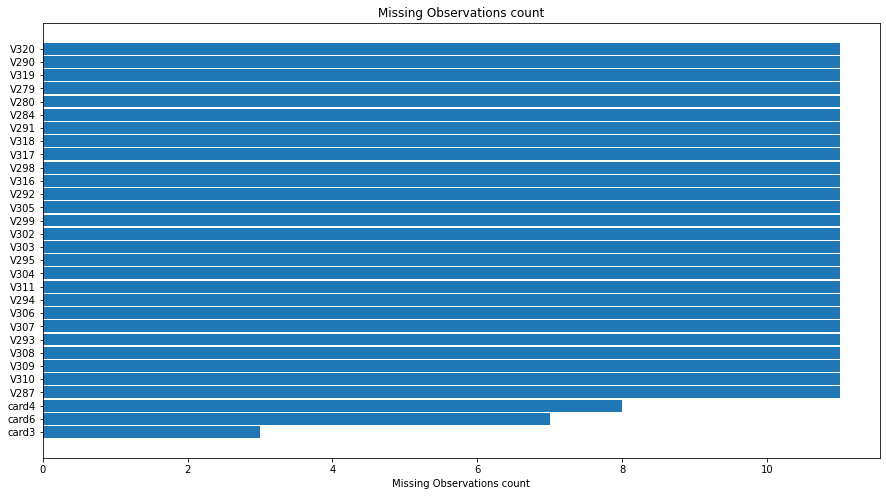

In [79]:
check_missings_using_horizontalbars(train)

In [80]:
#Заменяем на среднии
numerical_features = numerical_features.fillna(numerical_features.mean())

In [81]:
numerical_features.head(8)

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,86400,68.5,13926,368.326897,150.0,142.0,315.0,87.0,19.000000,240.962443,...,0.137074,74.962242,99.220468,85.778161,8.326725,18.404676,12.437524,26.798593,32.005349,28.492421
1,86401,29.0,2755,404.000000,150.0,102.0,325.0,87.0,126.243231,240.962443,...,0.137074,74.962242,99.220468,85.778161,8.326725,18.404676,12.437524,26.798593,32.005349,28.492421
2,86469,59.0,4663,490.000000,150.0,166.0,330.0,87.0,287.000000,240.962443,...,0.137074,74.962242,99.220468,85.778161,8.326725,18.404676,12.437524,26.798593,32.005349,28.492421
3,86499,50.0,18132,567.000000,150.0,117.0,476.0,87.0,126.243231,240.962443,...,0.137074,74.962242,99.220468,85.778161,8.326725,18.404676,12.437524,26.798593,32.005349,28.492421
4,86506,50.0,4497,514.000000,150.0,102.0,420.0,87.0,126.243231,240.962443,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,86510,49.0,5937,555.000000,150.0,226.0,272.0,87.0,36.000000,240.962443,...,0.137074,74.962242,99.220468,85.778161,8.326725,18.404676,12.437524,26.798593,32.005349,28.492421
6,86522,159.0,12308,360.000000,150.0,166.0,126.0,87.0,0.000000,240.962443,...,0.137074,74.962242,99.220468,85.778161,8.326725,18.404676,12.437524,26.798593,32.005349,28.492421
7,86529,422.5,12695,490.000000,150.0,226.0,325.0,87.0,126.243231,240.962443,...,0.137074,74.962242,99.220468,85.778161,8.326725,18.404676,12.437524,26.798593,32.005349,28.492421


In [114]:
data=numerical_features

Анализ целевого признака

In [115]:
target=train['isFraud']

In [116]:
print("число уникальных y:",train['isFraud'].nunique())
print("уникальные y:",train['isFraud'].unique())

число уникальных y: 2
уникальные y: [0 1]


In [117]:
dataset_target = pd.DataFrame(train['isFraud'])

In [118]:
check_missings_using_horizontalbars(dataset_target)

число признаков с пропусками 0


Тренировка модели где используется Hold-Out валидация (валидация на отложенной выборке)

In [119]:
x_train, x_valid = train_test_split(
    data, train_size=0.8, random_state=1
)
y_train, y_valid = train_test_split(
    target, train_size=0.8, random_state=1
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 144000 rows, 378 cols
x_valid.shape = 36000 rows, 378 cols


In [120]:
train_scores = pd.DataFrame({"target": y_train}) 
valid_scores = pd.DataFrame({"target": y_valid})

In [121]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,    
    "reg_lambda": 10,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 8,
    "seed": 27,
    "n_estimators":1000
}

In [122]:
model_xgb1 = xgb.XGBClassifier(**params)
model_xgb1.fit(
    X=x_train,
    y=y_train,    
    early_stopping_rounds=100,   
    eval_set=[(x_train, y_train), (x_valid, y_valid)],    
    eval_metric="auc",
    verbose=10    
)

C:\Users\Windows\.conda\envs\tf\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.63480	validation_1-auc:0.63095
[10]	validation_0-auc:0.80343	validation_1-auc:0.80518
[20]	validation_0-auc:0.84160	validation_1-auc:0.83599
[30]	validation_0-auc:0.87001	validation_1-auc:0.86569
[40]	validation_0-auc:0.87989	validation_1-auc:0.87202
[50]	validation_0-auc:0.88927	validation_1-auc:0.87842
[60]	validation_0-auc:0.89424	validation_1-auc:0.88405
[70]	validation_0-auc:0.89846	validation_1-auc:0.88884
[80]	validation_0-auc:0.90196	validation_1-auc:0.89145
[90]	validation_0-auc:0.90443	validation_1-auc:0.89381
[100]	validation_0-auc:0.90648	validation_1-auc:0.89578
[110]	validation_0-auc:0.90863	validation_1-auc:0.89741
[120]	validation_0-auc:0.91053	validation_1-auc:0.89948
[130]	validation_0-auc:0.91150	validation_1-auc:0.90006
[140]	validation_0-auc:0.91150	validation_1-auc:0.90006
[150]	validation_0-auc:0.91150	validation_1-auc:0.90006
[160]	validation_0-auc:0.91150	validation_1-auc:0.90006
[170]	validation_0-auc:0.91150	validation_1-auc:0.90006
[18

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=10, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=8, nthread=8,
              num_parallel_tree=1, random_state=27, reg_alpha=0, reg_lambda=10,
              scale_pos_weight=1, seed=27, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [123]:
train_scores["XGBoost_gbtree_num_features"] = model_xgb1.predict_proba(x_train)[:,1]
valid_scores["XGBoost_gbtree_num_features"] = model_xgb1.predict_proba(x_valid)[:,1]

**Задание 2:**

**выполнить задание 1, но с параметром booster = gblinear. Как изменилось качество, при использовании градиетного бустинга над решающими деревьями и при использовании бустинга над линейными моделями?**

In [124]:
params_linear = {
    "booster": "gblinear",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "reg_lambda": 10,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

In [125]:
model_xgb_linear = xgb.XGBClassifier(**params)
model_xgb_linear.fit(
    X=x_train,
    y=y_train,    
    early_stopping_rounds=100,   
    eval_set=[(x_train, y_train), (x_valid, y_valid)],    
    eval_metric="auc",
    verbose=10    
)

[0]	validation_0-auc:0.63480	validation_1-auc:0.63095
[10]	validation_0-auc:0.80343	validation_1-auc:0.80518
[20]	validation_0-auc:0.84160	validation_1-auc:0.83599
[30]	validation_0-auc:0.87001	validation_1-auc:0.86569
[40]	validation_0-auc:0.87989	validation_1-auc:0.87202
[50]	validation_0-auc:0.88927	validation_1-auc:0.87842
[60]	validation_0-auc:0.89424	validation_1-auc:0.88405
[70]	validation_0-auc:0.89846	validation_1-auc:0.88884
[80]	validation_0-auc:0.90196	validation_1-auc:0.89145
[90]	validation_0-auc:0.90443	validation_1-auc:0.89381
[100]	validation_0-auc:0.90648	validation_1-auc:0.89578
[110]	validation_0-auc:0.90863	validation_1-auc:0.89741
[120]	validation_0-auc:0.91053	validation_1-auc:0.89948
[130]	validation_0-auc:0.91150	validation_1-auc:0.90006
[140]	validation_0-auc:0.91150	validation_1-auc:0.90006
[150]	validation_0-auc:0.91150	validation_1-auc:0.90006
[160]	validation_0-auc:0.91150	validation_1-auc:0.90006
[170]	validation_0-auc:0.91150	validation_1-auc:0.90006
[18

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=10, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=8, nthread=8,
              num_parallel_tree=1, random_state=27, reg_alpha=0, reg_lambda=10,
              scale_pos_weight=1, seed=27, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [126]:
train_scores["XGBoost_gblinear_num_features"] = model_xgb_linear.predict_proba(x_train)[:,1]
valid_scores["XGBoost_gblinear_num_features"] = model_xgb_linear.predict_proba(x_valid)[:,1]

Вывод: качество практически не изменилось

**Задание 3:**

**обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 1.**

In [127]:
categorical_features = train.select_dtypes(include=["object"])

In [128]:
categorical_features

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,W,discover,credit,NaN,NaN,T,T,T,M2,F,T,NaN,NaN,NaN
1,W,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,W,visa,debit,outlook.com,NaN,T,T,T,M0,F,F,F,F,F
3,W,mastercard,debit,yahoo.com,NaN,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,H,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179995,W,mastercard,debit,gmail.com,NaN,T,T,F,M1,T,F,NaN,NaN,NaN
179996,W,mastercard,debit,yahoo.com,NaN,NaN,NaN,NaN,NaN,NaN,T,NaN,NaN,NaN
179997,W,mastercard,debit,gmail.com,NaN,T,T,T,M0,T,F,NaN,NaN,NaN
179998,W,visa,debit,NaN,NaN,NaN,NaN,NaN,M1,T,T,NaN,NaN,NaN


In [129]:
categorical_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180000 entries, 0 to 179999
Data columns (total 14 columns):
ProductCD        180000 non-null object
card4            179992 non-null object
card6            179993 non-null object
P_emaildomain    151560 non-null object
R_emaildomain    60300 non-null object
M1               61749 non-null object
M2               61749 non-null object
M3               61749 non-null object
M4               83276 non-null object
M5               61703 non-null object
M6               105652 non-null object
M7               31652 non-null object
M8               31652 non-null object
M9               31652 non-null object
dtypes: object(14)
memory usage: 19.2+ MB


In [130]:
for col in categorical_features.columns:
    print(col, categorical_features[col].nunique())

ProductCD 5
card4 4
card6 4
P_emaildomain 59
R_emaildomain 60
M1 2
M2 2
M3 2
M4 3
M5 2
M6 2
M7 2
M8 2
M9 2


In [131]:
from sklearn.preprocessing import OneHotEncoder

def handle_categorical_data(data, categorical_features):
    enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
    for col in categorical_features.columns:
        ohe_ftrs = enc.fit_transform(categorical_features[col].values.reshape(-1,1))
        tmp = pd.DataFrame(ohe_ftrs, columns = [col + '_' + str(i) for i in range(ohe_ftrs.shape[1])])
        data = pd.concat([data, tmp], axis=1)
    return data
    

In [132]:
data = handle_categorical_data(data, categorical_features)

In [133]:
data

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,...,M6_2,M7_0,M7_1,M7_2,M8_0,M8_1,M8_2,M9_0,M9_1,M9_2
0,86400,68.50,13926,368.326897,150.0,142.0,315.0,87.0,19.000000,240.962443,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,86401,29.00,2755,404.000000,150.0,102.0,325.0,87.0,126.243231,240.962443,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,86469,59.00,4663,490.000000,150.0,166.0,330.0,87.0,287.000000,240.962443,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,86499,50.00,18132,567.000000,150.0,117.0,476.0,87.0,126.243231,240.962443,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,86506,50.00,4497,514.000000,150.0,102.0,420.0,87.0,126.243231,240.962443,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179995,3958217,39.00,1877,310.000000,150.0,224.0,272.0,87.0,12.000000,240.962443,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
179996,3958237,59.95,10075,514.000000,150.0,224.0,315.0,87.0,126.243231,240.962443,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
179997,3958241,34.00,6053,122.000000,150.0,195.0,330.0,87.0,126.243231,240.962443,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
179998,3958260,59.00,7726,555.000000,150.0,226.0,272.0,87.0,126.243231,240.962443,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [134]:
x_train, x_valid = train_test_split(
    data, train_size=0.8, random_state=1
)

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 144000 rows, 542 cols
x_valid.shape = 36000 rows, 542 cols


In [135]:
model_xgb2 = xgb.XGBClassifier(**params)
model_xgb2.fit(
    X=x_train,
    y=y_train,    
    early_stopping_rounds=100,   
    eval_set=[(x_train, y_train), (x_valid, y_valid)],    
    eval_metric="auc",
    verbose=10    
)

C:\Users\Windows\.conda\envs\tf\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.63480	validation_1-auc:0.63095
[10]	validation_0-auc:0.79572	validation_1-auc:0.80040
[20]	validation_0-auc:0.84287	validation_1-auc:0.83828
[30]	validation_0-auc:0.87449	validation_1-auc:0.86946
[40]	validation_0-auc:0.88469	validation_1-auc:0.87968
[50]	validation_0-auc:0.89465	validation_1-auc:0.88727
[60]	validation_0-auc:0.90099	validation_1-auc:0.89235
[70]	validation_0-auc:0.90729	validation_1-auc:0.89704
[80]	validation_0-auc:0.91181	validation_1-auc:0.90054
[90]	validation_0-auc:0.91485	validation_1-auc:0.90329
[100]	validation_0-auc:0.91717	validation_1-auc:0.90484
[110]	validation_0-auc:0.91882	validation_1-auc:0.90594
[120]	validation_0-auc:0.92038	validation_1-auc:0.90723
[130]	validation_0-auc:0.92184	validation_1-auc:0.90794
[140]	validation_0-auc:0.92184	validation_1-auc:0.90794
[150]	validation_0-auc:0.92184	validation_1-auc:0.90794
[160]	validation_0-auc:0.92184	validation_1-auc:0.90794
[170]	validation_0-auc:0.92184	validation_1-auc:0.90794
[18

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=10, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=8, nthread=8,
              num_parallel_tree=1, random_state=27, reg_alpha=0, reg_lambda=10,
              scale_pos_weight=1, seed=27, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [136]:
train_scores["XGBoost_gbtree_all_features"] = model_xgb2.predict_proba(x_train)[:,1]
valid_scores["XGBoost_gbtree_all_features"] = model_xgb2.predict_proba(x_valid)[:,1]

**Задание 4:**

**для числовых признаков обучить модель LightGBM. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).**

In [137]:
data=numerical_features
data.head()

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,86400,68.5,13926,368.326897,150.0,142.0,315.0,87.0,19.000000,240.962443,...,0.137074,74.962242,99.220468,85.778161,8.326725,18.404676,12.437524,26.798593,32.005349,28.492421
1,86401,29.0,2755,404.000000,150.0,102.0,325.0,87.0,126.243231,240.962443,...,0.137074,74.962242,99.220468,85.778161,8.326725,18.404676,12.437524,26.798593,32.005349,28.492421
2,86469,59.0,4663,490.000000,150.0,166.0,330.0,87.0,287.000000,240.962443,...,0.137074,74.962242,99.220468,85.778161,8.326725,18.404676,12.437524,26.798593,32.005349,28.492421
3,86499,50.0,18132,567.000000,150.0,117.0,476.0,87.0,126.243231,240.962443,...,0.137074,74.962242,99.220468,85.778161,8.326725,18.404676,12.437524,26.798593,32.005349,28.492421
4,86506,50.0,4497,514.000000,150.0,102.0,420.0,87.0,126.243231,240.962443,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [138]:
!pip install lightgbm

You should consider upgrading via the 'C:\Users\Windows\.conda\envs\tf\python.exe -m pip install --upgrade pip' command.


In [139]:
import numpy as np
import lightgbm as lgb

In [140]:
x_train, x_valid = train_test_split(
    data, train_size=0.8, random_state=1
)

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 144000 rows, 378 cols
x_valid.shape = 36000 rows, 378 cols


In [144]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 1000,
    "n_jobs": 8,
    "seed": 27,
    "early_stopping_rounds":100
}


In [145]:
model_lgb1 = lgb.LGBMClassifier(**params)
model_lgb1.fit(
    X=x_train,
    y=y_train,
    eval_set=[(x_train, y_train), (x_valid, y_valid)],
    early_stopping_rounds=100,
    eval_metric="auc",
    verbose=10,
    categorical_feature="auto"
)


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	training's auc: 0.829353	valid_1's auc: 0.825433
[20]	training's auc: 0.839031	valid_1's auc: 0.835301
[30]	training's auc: 0.866157	valid_1's auc: 0.86137
[40]	training's auc: 0.875958	valid_1's auc: 0.869569
[50]	training's auc: 0.879494	valid_1's auc: 0.871538
[60]	training's auc: 0.882076	valid_1's auc: 0.874725
[70]	training's auc: 0.883863	valid_1's auc: 0.876275
[80]	training's auc: 0.885469	valid_1's auc: 0.877282
[90]	training's auc: 0.88727	valid_1's auc: 0.879026
[100]	training's auc: 0.890232	valid_1's auc: 0.880727
[110]	training's auc: 0.891972	valid_1's auc: 0.882365
[120]	training's auc: 0.894417	valid_1's auc: 0.883963
[130]	training's auc: 0.896546	valid_1's auc: 0.885021
[140]	training's auc: 0.900115	valid_1's auc: 0.886313
[150]	training's auc: 0.901797	valid_1's auc: 0.887644
[160]	training's auc: 0.903103	valid_1's auc: 0.888774
[170]	training's auc: 0.90498	valid_1's auc: 0.889953
[180]	training's auc: 0.906599	valid_1's auc: 0.891034
[190]	training's auc: 

LGBMClassifier(early_stopping_rounds=100, learning_rate=0.01, metric='auc',
               n_estimators=1000, n_jobs=8, objective='binary', seed=27)

In [146]:
train_scores["LGBM_gbtree_numerical_features"] = model_lgb1.predict_proba(x_train)[:,1]
valid_scores["LGBM_gbtree_numerical_features"] = model_lgb1.predict_proba(x_valid)[:,1]

**Задание 5:**

**обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 4.**

In [147]:
data = handle_categorical_data(data, categorical_features)
data

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,...,M6_2,M7_0,M7_1,M7_2,M8_0,M8_1,M8_2,M9_0,M9_1,M9_2
0,86400,68.50,13926,368.326897,150.0,142.0,315.0,87.0,19.000000,240.962443,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,86401,29.00,2755,404.000000,150.0,102.0,325.0,87.0,126.243231,240.962443,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,86469,59.00,4663,490.000000,150.0,166.0,330.0,87.0,287.000000,240.962443,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,86499,50.00,18132,567.000000,150.0,117.0,476.0,87.0,126.243231,240.962443,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,86506,50.00,4497,514.000000,150.0,102.0,420.0,87.0,126.243231,240.962443,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179995,3958217,39.00,1877,310.000000,150.0,224.0,272.0,87.0,12.000000,240.962443,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
179996,3958237,59.95,10075,514.000000,150.0,224.0,315.0,87.0,126.243231,240.962443,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
179997,3958241,34.00,6053,122.000000,150.0,195.0,330.0,87.0,126.243231,240.962443,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
179998,3958260,59.00,7726,555.000000,150.0,226.0,272.0,87.0,126.243231,240.962443,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [148]:
x_train, x_valid = train_test_split(
    data, train_size=0.8, random_state=1
)

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 144000 rows, 542 cols
x_valid.shape = 36000 rows, 542 cols


In [149]:
model_lgb2 = lgb.LGBMClassifier(**params)
model_lgb2.fit(
    X=x_train,
    y=y_train,
    eval_set=[(x_train, y_train), (x_valid, y_valid)],
    early_stopping_rounds=100,
    eval_metric="auc",
    verbose=100,
    categorical_feature="auto"
)


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[100]	training's auc: 0.898147	valid_1's auc: 0.890527
[200]	training's auc: 0.915231	valid_1's auc: 0.901965
[300]	training's auc: 0.932615	valid_1's auc: 0.915138
[400]	training's auc: 0.942762	valid_1's auc: 0.922211
[500]	training's auc: 0.952281	valid_1's auc: 0.929013
[600]	training's auc: 0.95856	valid_1's auc: 0.933389
[700]	training's auc: 0.963117	valid_1's auc: 0.936388
[800]	training's auc: 0.966911	valid_1's auc: 0.938689
[900]	training's auc: 0.970695	valid_1's auc: 0.940885
[1000]	training's auc: 0.973716	valid_1's auc: 0.942584


LGBMClassifier(early_stopping_rounds=100, learning_rate=0.01, metric='auc',
               n_estimators=1000, n_jobs=8, objective='binary', seed=27)

In [150]:
train_scores["LGBM_gbtree_all_features"] = model_lgb2.predict_proba(x_train)[:,1]
valid_scores["LGBM_gbtree_all_features"] = model_lgb2.predict_proba(x_valid)[:,1]

**Задание 6:** 

**обработать категориальные признаки встроенным методом в LightGBM. Выполнить задание 4. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 5.**

In [151]:
cat_feats =[]
for col in categorical_features.columns:
    cat_feats.append(col)
cat_feats

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9']

In [152]:
data=numerical_features

In [153]:
categorical_features.fillna(0)

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,W,discover,credit,0,0,T,T,T,M2,F,T,0,0,0
1,W,mastercard,credit,gmail.com,0,0,0,0,M0,T,T,0,0,0
2,W,visa,debit,outlook.com,0,T,T,T,M0,F,F,F,F,F
3,W,mastercard,debit,yahoo.com,0,0,0,0,M0,T,F,0,0,0
4,H,mastercard,credit,gmail.com,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179995,W,mastercard,debit,gmail.com,0,T,T,F,M1,T,F,0,0,0
179996,W,mastercard,debit,yahoo.com,0,0,0,0,0,0,T,0,0,0
179997,W,mastercard,debit,gmail.com,0,T,T,T,M0,T,F,0,0,0
179998,W,visa,debit,0,0,0,0,0,M1,T,T,0,0,0


In [154]:
from sklearn.preprocessing import LabelEncoder

def handle_by_simple_method_categorical_data(data, categorical_features):
    enc = LabelEncoder()
    for col in categorical_features.columns:
        ohe_ftrs = enc.fit_transform(categorical_features[col])
        tmp = pd.DataFrame(ohe_ftrs,columns = [col])
        data = pd.concat([data, tmp], axis=1)
    return data

In [155]:
data=handle_by_simple_method_categorical_data(data, categorical_features)
data

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,...,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,86400,68.50,13926,368.326897,150.0,142.0,315.0,87.0,19.000000,240.962443,...,60,1,1,1,2,0,1,2,2,2
1,86401,29.00,2755,404.000000,150.0,102.0,325.0,87.0,126.243231,240.962443,...,60,2,2,2,0,1,1,2,2,2
2,86469,59.00,4663,490.000000,150.0,166.0,330.0,87.0,287.000000,240.962443,...,60,1,1,1,0,0,0,0,0,0
3,86499,50.00,18132,567.000000,150.0,117.0,476.0,87.0,126.243231,240.962443,...,60,2,2,2,0,1,0,2,2,2
4,86506,50.00,4497,514.000000,150.0,102.0,420.0,87.0,126.243231,240.962443,...,60,2,2,2,3,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179995,3958217,39.00,1877,310.000000,150.0,224.0,272.0,87.0,12.000000,240.962443,...,60,1,1,0,1,1,0,2,2,2
179996,3958237,59.95,10075,514.000000,150.0,224.0,315.0,87.0,126.243231,240.962443,...,60,2,2,2,3,2,1,2,2,2
179997,3958241,34.00,6053,122.000000,150.0,195.0,330.0,87.0,126.243231,240.962443,...,60,1,1,1,0,1,0,2,2,2
179998,3958260,59.00,7726,555.000000,150.0,226.0,272.0,87.0,126.243231,240.962443,...,60,2,2,2,1,1,1,2,2,2


In [156]:
x_train, x_valid = train_test_split(
    data, train_size=0.8, random_state=1
)

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 144000 rows, 392 cols
x_valid.shape = 36000 rows, 392 cols


In [158]:
model_lgb3 = lgb.LGBMClassifier(**params)
model_lgb3.fit(
    X=x_train,
    y=y_train,
    eval_set=[(x_train, y_train), (x_valid, y_valid)],
    early_stopping_rounds=100,
    eval_metric="auc",
    verbose=100,
    categorical_feature=cat_feats    
)


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[100]	training's auc: 0.902641	valid_1's auc: 0.890744
[200]	training's auc: 0.919803	valid_1's auc: 0.903682
[300]	training's auc: 0.934527	valid_1's auc: 0.914347
[400]	training's auc: 0.944809	valid_1's auc: 0.921889
[500]	training's auc: 0.953024	valid_1's auc: 0.927771
[600]	training's auc: 0.95897	valid_1's auc: 0.932474
[700]	training's auc: 0.963471	valid_1's auc: 0.934947
[800]	training's auc: 0.967826	valid_1's auc: 0.936727
[900]	training's auc: 0.971018	valid_1's auc: 0.938631
[1000]	training's auc: 0.974306	valid_1's auc: 0.94093


LGBMClassifier(early_stopping_rounds=100, learning_rate=0.01, metric='auc',
               n_estimators=1000, n_jobs=8, objective='binary', seed=27)

Выводы: по сравнению с ручным кодированиям через OneHotEncoder алгоритм существенно не выиграл, даже метрика auc: 0.942584 в случае ручного кодирования категорийных признаков на валидационном датасете лучше, чем при кодировании встроеннным методом lightgbm - auc: 0.94093, также требующего еще и предварительного преобразование в числовую форму, хотя на тренировочном датасете эта метрика немного лучше.

In [159]:
train_scores["LGBM_gbtree_inner_categorical_all_features"] = model_lgb3.predict_proba(x_train)[:,1]
valid_scores["LGBM_gbtree_inner_categorical_all_features"] = model_lgb3.predict_proba(x_valid)[:,1]

**Задание 7:**

**для числовых признаков обучить модель CatBoost. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).**

In [170]:
data=numerical_features

In [161]:
x_train, x_valid = train_test_split(
    data, train_size=0.8, random_state=1
)
y_train, y_valid = train_test_split(
    target, train_size=0.8, random_state=1
)
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 144000 rows, 378 cols
x_valid.shape = 36000 rows, 378 cols


In [162]:
!pip install catboost

You should consider upgrading via the 'C:\Users\Windows\.conda\envs\tf\python.exe -m pip install --upgrade pip' command.


In [163]:
import catboost as cb

In [164]:
cb_params = {
    "n_estimators": 1000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 30,
    "verbose": 200,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 100,
    "thread_count": 8,
    "random_seed": 42,
    "use_best_model": True,
    "learning_rate": 0.05   
}

In [165]:
model_cb1 = cb.CatBoostClassifier(**cb_params)
model_cb1.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6822113	test1: 0.6775167	best: 0.6775167 (0)	total: 63.8ms	remaining: 1m 3s
200:	test: 0.8895076	test1: 0.8811993	best: 0.8811993 (200)	total: 8.48s	remaining: 33.7s
400:	test: 0.8968787	test1: 0.8873331	best: 0.8873331 (400)	total: 16.7s	remaining: 25s
600:	test: 0.9025052	test1: 0.8928039	best: 0.8928119 (594)	total: 25.1s	remaining: 16.7s
800:	test: 0.9071002	test1: 0.8967351	best: 0.8967361 (797)	total: 33.5s	remaining: 8.32s
999:	test: 0.9099429	test1: 0.8987141	best: 0.8987154 (997)	total: 42s	remaining: 0us

bestTest = 0.8987153985
bestIteration = 997

Shrink model to first 998 iterations.


In [168]:
train_scores["CatBoost_gbtree_numerical_features"] = model_cb1.predict_proba(x_train)[:,1]
valid_scores["CatBoost_gbtree_numerical_features"] = model_cb1.predict_proba(x_valid)[:,1]

**Задание 8:**

**обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 7.**

In [171]:
data = handle_categorical_data(data, categorical_features)
data

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,...,M6_2,M7_0,M7_1,M7_2,M8_0,M8_1,M8_2,M9_0,M9_1,M9_2
0,86400,68.50,13926,368.326897,150.0,142.0,315.0,87.0,19.000000,240.962443,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,86401,29.00,2755,404.000000,150.0,102.0,325.0,87.0,126.243231,240.962443,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,86469,59.00,4663,490.000000,150.0,166.0,330.0,87.0,287.000000,240.962443,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,86499,50.00,18132,567.000000,150.0,117.0,476.0,87.0,126.243231,240.962443,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,86506,50.00,4497,514.000000,150.0,102.0,420.0,87.0,126.243231,240.962443,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179995,3958217,39.00,1877,310.000000,150.0,224.0,272.0,87.0,12.000000,240.962443,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
179996,3958237,59.95,10075,514.000000,150.0,224.0,315.0,87.0,126.243231,240.962443,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
179997,3958241,34.00,6053,122.000000,150.0,195.0,330.0,87.0,126.243231,240.962443,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
179998,3958260,59.00,7726,555.000000,150.0,226.0,272.0,87.0,126.243231,240.962443,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [172]:
x_train, x_valid = train_test_split(
    data, train_size=0.8, random_state=1
)

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 144000 rows, 542 cols
x_valid.shape = 36000 rows, 542 cols


In [173]:
model_cb2 = cb.CatBoostClassifier(**cb_params)
model_cb2.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6352077	test1: 0.6343132	best: 0.6343132 (0)	total: 62.7ms	remaining: 1m 2s
200:	test: 0.8990226	test1: 0.8903940	best: 0.8903940 (200)	total: 9.16s	remaining: 36.4s
400:	test: 0.9080195	test1: 0.8991129	best: 0.8991129 (400)	total: 18.3s	remaining: 27.3s
600:	test: 0.9109284	test1: 0.9015430	best: 0.9015540 (587)	total: 26.9s	remaining: 17.9s
800:	test: 0.9138135	test1: 0.9036813	best: 0.9036813 (800)	total: 35.8s	remaining: 8.88s
999:	test: 0.9159741	test1: 0.9054174	best: 0.9054174 (998)	total: 44.7s	remaining: 0us

bestTest = 0.9054174496
bestIteration = 998

Shrink model to first 999 iterations.


In [174]:
train_scores["CatBoost_gbtree_all_features"] = model_cb2.predict_proba(x_train)[:,1]
valid_scores["CatBoost_gbtree_all_features"] = model_cb2.predict_proba(x_valid)[:,1]

**Задание 9:**

**обработать категориальные признаки встроенным методом в CatBoost. Выполнить задание 7. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 8.**

In [175]:
data=numerical_features

In [176]:
categorical_features=categorical_features.fillna('')

In [177]:
data = pd.concat([data, categorical_features], axis=1)
data

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,...,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,86400,68.50,13926,368.326897,150.0,142.0,315.0,87.0,19.000000,240.962443,...,,T,T,T,M2,F,T,,,
1,86401,29.00,2755,404.000000,150.0,102.0,325.0,87.0,126.243231,240.962443,...,,,,,M0,T,T,,,
2,86469,59.00,4663,490.000000,150.0,166.0,330.0,87.0,287.000000,240.962443,...,,T,T,T,M0,F,F,F,F,F
3,86499,50.00,18132,567.000000,150.0,117.0,476.0,87.0,126.243231,240.962443,...,,,,,M0,T,F,,,
4,86506,50.00,4497,514.000000,150.0,102.0,420.0,87.0,126.243231,240.962443,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179995,3958217,39.00,1877,310.000000,150.0,224.0,272.0,87.0,12.000000,240.962443,...,,T,T,F,M1,T,F,,,
179996,3958237,59.95,10075,514.000000,150.0,224.0,315.0,87.0,126.243231,240.962443,...,,,,,,,T,,,
179997,3958241,34.00,6053,122.000000,150.0,195.0,330.0,87.0,126.243231,240.962443,...,,T,T,T,M0,T,F,,,
179998,3958260,59.00,7726,555.000000,150.0,226.0,272.0,87.0,126.243231,240.962443,...,,,,,M1,T,T,,,


In [178]:
x_train, x_valid = train_test_split(
    data, train_size=0.8, random_state=1
)

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))

x_train.shape = 144000 rows, 392 cols
x_valid.shape = 36000 rows, 392 cols


In [179]:
model_cb3 = cb.CatBoostClassifier(**cb_params)
model_cb3.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], cat_features=cat_feats,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6462261	test1: 0.6418749	best: 0.6418749 (0)	total: 253ms	remaining: 4m 13s
200:	test: 0.8964311	test1: 0.8882608	best: 0.8882608 (200)	total: 46.3s	remaining: 3m 4s
400:	test: 0.9059316	test1: 0.8962525	best: 0.8962556 (397)	total: 1m 32s	remaining: 2m 18s
600:	test: 0.9115239	test1: 0.9002695	best: 0.9002938 (599)	total: 2m 19s	remaining: 1m 32s
800:	test: 0.9148143	test1: 0.9028350	best: 0.9028350 (800)	total: 3m 4s	remaining: 45.9s
999:	test: 0.9170093	test1: 0.9047538	best: 0.9047551 (998)	total: 3m 50s	remaining: 0us

bestTest = 0.9047550792
bestIteration = 998

Shrink model to first 999 iterations.


In [180]:
train_scores["CatBoost_gbtree_inner_categorical_all_features"] = model_cb3.predict_proba(x_train)[:,1]
valid_scores["CatBoost_gbtree_inner_categorical_all_features"] = model_cb3.predict_proba(x_valid)[:,1]

Выводы: При обработке категориальных признаков встроенным методом в CatBoost результаты метрики roc-auc  получаются немного хуже.  для ручного кодирования лучший roc-auc=0.9135574214, а для кодирования встроенного в CatBoost лучший roc-auc=9132636778 (на n_estimators=10000)

**Задание 10:**

**построить ROC-кривую для всех построенных алгоритмов на обучающей и тестовой выборке. Сделать выводы о работе алгоритмов с точки зрения качества на тестовой выборке и с точки зрения переобучения.**

In [183]:
from sklearn.metrics import roc_auc_score, roc_curve

In [197]:
def plot_curves(valid_scores_par: pd.DataFrame, train_scores_par: pd.DataFrame) -> None:
    """
    Построение ROC-Curve для множества построенных моделей.

    Parameters
    ----------
    valid_scores: pandas.core.frame.DataFrame
        Датафрем с прогнозами модели на валидационной выборке.

    train_scores: pandas.core.frame.DataFrame
        Датафрейм с прогнозами модели на обучающей выборке.

    """
    fig = plt.figure(figsize=(15, 5))
    columns = set(valid_scores_par.columns) - set(["target"])

    plt.subplot(121)
    plt.xlabel("FPR", size=14)
    plt.ylabel("TPR", size=14)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title("Train ROC curve")

    for feature in columns:
        fpr, tpr, _ = roc_curve(
            train_scores_par["target"], train_scores_par[feature]
        )
        plt.plot(fpr, tpr, linewidth=2, label=feature)

    plt.legend(loc="best")

    plt.subplot(122)
    plt.xlabel("FPR", size=14)
    plt.ylabel("TPR", size=14)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title("Valid ROC curve")

    for feature in columns:
        fpr, tpr, _ = roc_curve(
            valid_scores_par["target"], valid_scores_par[feature]
        )
        plt.plot(fpr, tpr, linewidth=2, label=feature)
    plt.legend(loc="best")

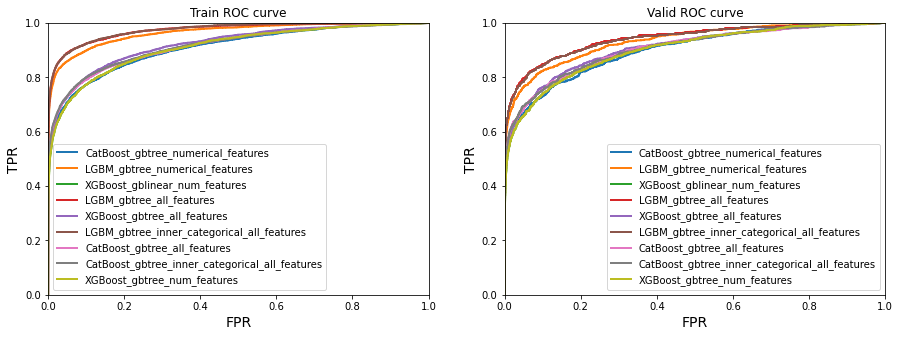

In [198]:
plot_curves(valid_scores, train_scores)

In [208]:
valid_scores_tmp = pd.DataFrame(valid_scores, columns=["LGBM_gbtree_all_features","target"])
train_scores_tmp = pd.DataFrame(train_scores, columns=["LGBM_gbtree_all_features","target"])

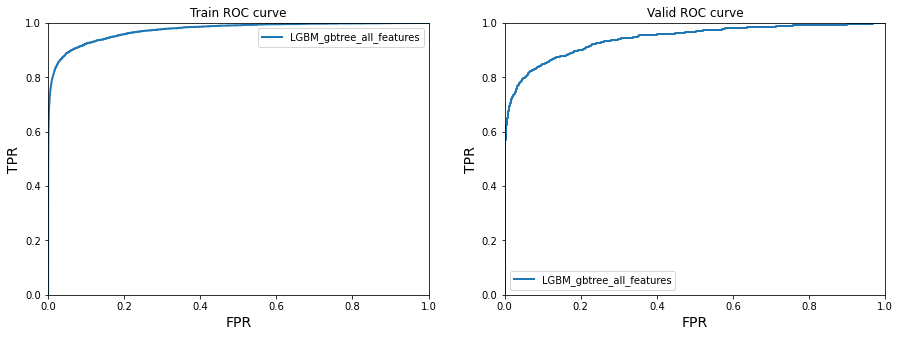

In [209]:
plot_curves(valid_scores_tmp,train_scores_tmp)

In [210]:
valid_scores_tmp = pd.DataFrame(valid_scores, columns=["LGBM_gbtree_inner_categorical_all_features","target"])
train_scores_tmp = pd.DataFrame(train_scores, columns=["LGBM_gbtree_inner_categorical_all_features","target"])

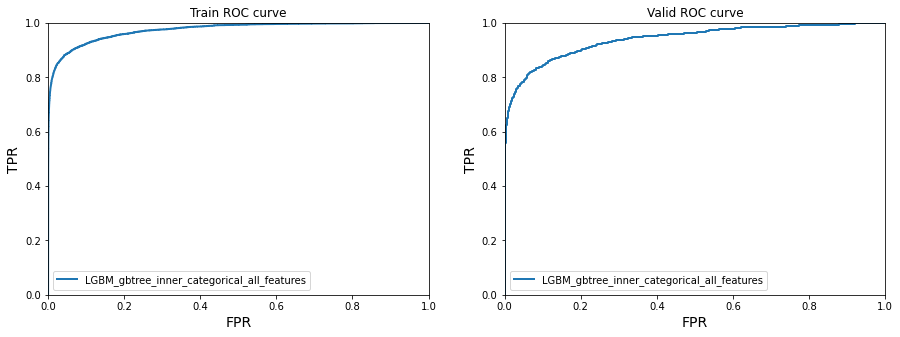

In [211]:
plot_curves(valid_scores_tmp,train_scores_tmp)

**Выводы:**
    
**точки зрения качества на тестовой выборке лучше всех себя показала модель LGBM с ручным кодированием категориальных переменных (OneHotEncoding) roc-auc: 0.942584,на 2 месте LGBM с встроенным кодированием roc-auc: 0.940**

**с точки зрения переобучения как раз все LGBM алгоритмы немного переобучились на train по сравнению с другими алгоритмами,
хотя общще качество на тестовой выборки у них все же лучше чем у других.**